## Language Analysis of Alexithymic Discourse

<hr>

Alexithymic Language Project / raul@psicobotica.com / V2 release (sept 2020)

<hr>

## Text classification with a Bidirectional Long Short Term Memory network (biLSTM)

### Including an attention mechanism for providing an explanation of the predictive model



## Libraries

In [7]:
# Data handling
import pandas as pd
import numpy as np

In [8]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Deep Learning with Keras
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [10]:
# Installing BERT
# !pip install transformers

In [11]:
# Using BERT (not here)
# import transformers

In [12]:
# importing my csv text formats
import ast

In [13]:
# Scikit Learn utils
from sklearn import metrics

## Load my dataset

In [30]:
feats_dataset_path = "https://raw.githubusercontent.com/raul-arrabales/alexithymic-lang/master/data/Prolexitim_v2_features_8.csv"

alex_df = pd.read_csv(feats_dataset_path, header=0, delimiter=";")

In [31]:
alex_df.columns[0:40]

Index(['Code', 'TAS20', 'F1', 'F2', 'F3', 'Gender', 'Age', 'Card',
       'T_Metaphors', 'T_ToM', 'T_FP', 'T_Interpret', 'T_Desc', 'T_Confussion',
       'Text', 'Alex_A', 'Alex_B', 'Words', 'Sentences', 'Tokens',
       'Tokens_Stop', 'Tokens_Stem_P', 'Tokens_Stem_S', 'POS', 'NER', 'DEP',
       'Lemmas_CNLP', 'Lemmas_Spacy', 'Chars', 'avgWL', 'avgSL', 'Pun_Count',
       'Stop_Count', 'RawTokens', 'Title_Count', 'Upper_Count', 'PRON_Count',
       'DET_Count', 'ADV_Count', 'VERB_Count'],
      dtype='object')

In [32]:
alex_df.sample(2)

,Code,TAS20,F1,F2,F3,Gender,Age,Card,T_Metaphors,T_ToM,T_FP,T_Interpret,T_Desc,T_Confussion,Text,Alex_A,Alex_B,Words,Sentences,Tokens,Tokens_Stop,Tokens_Stem_P,Tokens_Stem_S,POS,NER,DEP,Lemmas_CNLP,Lemmas_Spacy,Chars,avgWL,avgSL,Pun_Count,Stop_Count,RawTokens,Title_Count,Upper_Count,PRON_Count,DET_Count,ADV_Count,VERB_Count,...,consumption_preferences_start_business,consumption_preferences_movie_romance,consumption_preferences_movie_adventure,consumption_preferences_movie_horror,consumption_preferences_movie_musical,consumption_preferences_movie_historical,consumption_preferences_movie_science_fiction,consumption_preferences_movie_war,consumption_preferences_movie_drama,consumption_preferences_movie_action,consumption_preferences_movie_documentary,consumption_preferences_music_rap,consumption_preferences_music_country,consumption_preferences_music_r_b,consumption_preferences_music_hip_hop,consumption_preferences_music_live_event,consumption_preferences_music_playing,consumption_preferences_music_latin,consumption_preferences_music_rock,consumption_preferences_music_classical,consumption_preferences_read_frequency,consumption_preferences_books_entertainment_magazines,consumption_preferences_books_non_fiction,consumption_preferences_books_financial_investing,consumption_preferences_books_autobiographies,consumption_preferences_volunteer,MSP_Words,MSP_Stems,AFINN_Words_Pol,AFINN_Stems_Pol,AFINN_Words_Int,AFINN_Stems_Int,AFINN_Words_Max,AFINN_Stems_Max,Watson_Sent,Clean_Text,LDA4_Umap2_0,LDA4_Umap2_1,LDA10_Topic,LDA4_Topic
92,65e24a82d12f4a91135102a8a7eaab06,39,17,9,13,2,36,1,0,0,1,1,0,0,Pues no teníamos clase de música y voy y me du...,0,0,30,5,"['pues', 'no', 'teníamos', 'clase', 'de', 'mús...","['pues', 'clase', 'música', 'voy', 'duermo', '...","['pue', 'clase', 'música', 'voy', 'duermo', 'c...","['pues', 'clas', 'music', 'voy', 'duerm', 'cua...","[('pues', 'SCONJ'), ('no', 'ADV'), ('teníamos'...","[('pues', 'O'), ('no', 'O'), ('teníamos', 'O')...","[[(('teníamos', 'VERB'), 'mark', ('pues', 'SCO...",pues no teníamos clase de música y voy y I due...,"['pues', 'no', 'tener', 'clase', 'de', 'música...",133,4.433333,6.0,5,17,"['Pues', 'no', 'teníamos', 'clase', 'de', 'mús...",3,3,4,1,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.230769,0.153846,3,1,1.5,2.5,3,3,0.372589,pues clase música voy duermo cualquiera diría ...,-0.389296,6.269419,9,3
129,3d7431322c06c2f0836a2432d477973f,44,14,12,18,1,61,11,0,1,0,1,0,0,"La búsqueda no había resultado infrucuosa, el ...",0,0,51,3,"['la', 'búsqueda', 'no', 'había', 'resultado',...","['búsqueda', 'resultado', 'infrucuosa', 'sonid...","['búsqueda', 'resultado', 'infrucuosa', 'sonid...","['busqued', 'result', 'infrucu', 'son', 'sensa...","[('la', 'DET'), ('búsqueda', 'NOUN'), ('no', '...","[('la', 'O'), ('búsqueda', 'O'), ('no', 'O'), ...","[[(('resultado', 'VERB'), 'nsubj', ('búsqueda'...","la búsqueda no había resultado infrucuosa , el...","['el', 'búsqueda', 'no', 'había', 'resultar', ...",256,5.019608,17.0,4,26,"['La', 'búsqueda', 'no', 'había', 'resultado',...",2,2,3,8,5,8,...,0.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-0.200000,-0.320000,0,-2,2.0,6.0,2,7,0.403927,búsqueda resultado infrucuosa sonido sensación...,0.557478,6.673361,1,1


## Load Pre-trained Word Vectors

In [14]:
from gensim.models import KeyedVectors
import pyemd

In [15]:
# Dimensionality of vectors
NUM_DIM = 400

In [16]:
from google.colab import files
uploaded = files.upload()

Saving Prolexitim_v2_MyWord2Vec.csv to Prolexitim_v2_MyWord2Vec.csv


In [17]:
# 20 MB file with pre-trained word vectors (instead of the full 3GB Word2Vec file)
my_vectors = pd.read_csv('Prolexitim_v2_MyWord2Vec.csv', header=0, delimiter=";")

In [18]:
my_vectors.sample(4)

,word,vector
251,punto,"[-2.4219071865081787, -1.0893985033035278, 3.5..."
107,mañanas,"[-2.4971823692321777, 3.2532529830932617, -3.0..."
2476,atacarles,"[-0.4898538589477539, -1.8385465145111084, 0.7..."
2299,jaime,"[-1.9655661582946777, 0.9163540601730347, -0.7..."


In [19]:
my_vectors[my_vectors['word'] == 'decidió']['vector']

2169    [-3.240154266357422, -1.7901349067687988, 3.35...
Name: vector, dtype: object

In [20]:
my_vectors[my_vectors['word'] == 'decidió']['vector'].values

array(['[-3.240154266357422, -1.7901349067687988, 3.353377103805542, 1.6399216651916504, -0.9851885437965393, -0.7573761343955994, -0.1319102644920349, -2.604383707046509, -0.7085506916046143, 0.33221518993377686, -1.1286180019378662, 1.4342106580734253, 0.17469240725040436, -0.7540820240974426, -1.433244228363037, 0.007204042281955481, -0.05140113830566406, 1.6604589223861694, -0.5412502288818359, 0.11355430632829666, -2.1695127487182617, -0.3570452928543091, -1.8473812341690063, -0.30507487058639526, 0.9077266454696655, 0.07965555042028427, 2.2751524448394775, 0.24414795637130737, -1.8510997295379639, 0.8496582508087158, -0.023393386974930763, -0.7376925349235535, -0.5438008308410645, -0.10880938917398453, -2.2760491371154785, 2.5668444633483887, 0.884616494178772, -2.2656702995300293, 0.9524273872375488, 1.6825034618377686, 2.092249870300293, 1.125827431678772, 0.7442363500595093, -1.6205689907073975, 1.8329616785049438, -0.7965370416641235, 0.8949437141418457, 1.498968482017517, -2

In [21]:
# Obtain the vector corresponding to a specific word
# Returns a vector of zeroes if the word is not in my_vectors
def get_my_Word2Vec( word ):
  data = my_vectors[my_vectors['word'] == word]['vector'].values
  if data is not None:
    if len(data) > 0 :
      return ast.literal_eval(data[0])
    else:
      return np.zeros(NUM_DIM)  
  else: 
    return np.zeros(NUM_DIM)

In [22]:
len(get_my_Word2Vec('decidió'))

400

In [23]:
get_my_Word2Vec('decidió')[0:10]

[-3.240154266357422,
 -1.7901349067687988,
 3.353377103805542,
 1.6399216651916504,
 -0.9851885437965393,
 -0.7573761343955994,
 -0.1319102644920349,
 -2.604383707046509,
 -0.7085506916046143,
 0.33221518993377686]

In [24]:
len(get_my_Word2Vec('2387dh12390hd0'))

400

In [25]:
get_my_Word2Vec('2387dh12390hd0')[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Dataset Train/Test Split

In [26]:
from sklearn.model_selection import train_test_split

In [33]:
# X is texts and y is alexithymia class

X = list(alex_df['Tokens_Stop'].apply(lambda x: ast.literal_eval(x))) # Docs as list of clean tokens
y = alex_df['Alex_A'].values

In [34]:
alex_df['Text'][0]

'es un niño pensando en cual es la respuesta de sus deberes porque no la sabe.'

In [35]:
X[0:2]

[['niño', 'pensando', 'respuesta', 'deberes', 'sabe'],
 ['hombre', 'llorando', 'mujer', 'muerto']]

In [36]:
y[0:2]

array([0, 0])

In [37]:
len(X) == len(y)

True

In [38]:
 # Stratify y to keep same proportion of positives in both splits
 X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=0, 
                                                     stratify=y) 

In [96]:
X_train[0]

['hombre', 'despues', 'matar', 'mujer', 'ahogada', 'llora', 'hecho']

In [39]:
len(X_train)

270

In [40]:
len(y_test)

68

In [41]:
y_test

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0])

In [42]:
print("Positives ratio in test set: %.2f" % (sum(y_test)/len(y_test)))

Positives ratio in test set: 0.22


In [43]:
y_train

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0])

In [44]:
print("Positives ratio in train set: %.2f" % (sum(y_train)/len(y_train)))

Positives ratio in train set: 0.22


## Keras Text Preprocessing (Feature Vectors)

In [45]:
# Keras tokenizer
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

In [46]:
# Apply the tokenizer
tokenizer.fit_on_texts(X)

In [47]:
# We have an id per word
dic_vocabulary = tokenizer.word_index

In [48]:
dic_vocabulary['violín']

2

In [49]:
# Convert each doc into a sequence of word ids
text_seqs = tokenizer.texts_to_sequences(X_train)

In [50]:
text_seqs[1]

[2544, 5, 161, 2545, 24, 425, 162]

In [51]:
# Sequence lengths
lengths = [len(text_seqs[i]) for i in range(0,len(text_seqs))]

In [52]:
print("Max: " + str(np.max(lengths)))
print("Min: " + str(np.min(lengths)))
print("Mean: " + str(np.mean(lengths)))
print("Median: " + str(np.median(lengths)))
print("Stdev: " + str(np.std(lengths)))

Max: 75
Min: 2
Mean: 16.68148148148148
Median: 12.5
Stdev: 12.57784757647605


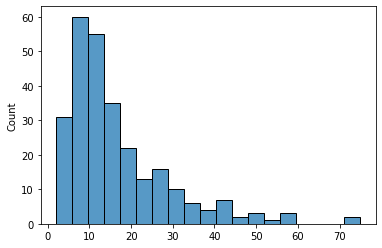

In [53]:
sns.histplot(lengths)

In [54]:
# Padding max length
MAX_LEN = 20

In [55]:
## padding sequence (paddind and truncating POST instead of PRE)
X_train_padded = kprocessing.sequence.pad_sequences(text_seqs, 
                    maxlen=MAX_LEN, padding="post", truncating="post")

In [56]:
X_train_padded[0:3]

array([[   4,  177,  277,    7, 2554,  245,  157,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [2544,    5,  161, 2545,   24,  425,  162,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1597,    8,  753,   53,   10,  342,  138,   93,   27,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

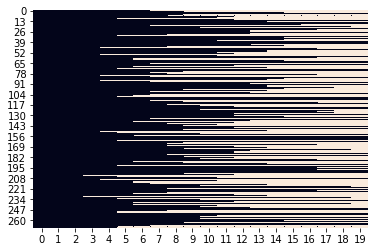

In [57]:
sns.heatmap(X_train_padded==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [58]:
# Same preprocessing for test set: 
text_seqs_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = kprocessing.sequence.pad_sequences(text_seqs_test, 
                    maxlen=MAX_LEN, padding="post", truncating="post")

In [59]:
X_test_padded

array([[1211, 1212, 1213, ...,    0,    0,    0],
       [ 779,  244,   13, ...,    0,    0,    0],
       [  28,  825,  109, ...,    0,    0,    0],
       ...,
       [1603, 1604,  362, ...,    0,    0,    0],
       [   5,  233, 2246, ..., 2251,   24,  843],
       [   4,  117,    7, ...,    0,    0,    0]], dtype=int32)

## Building biLSTM model

In [60]:
# Create the matrix with word vectors:
embeddings = np.zeros((len(dic_vocabulary)+1, 400))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    embeddings[idx] = get_my_Word2Vec(word)

In [61]:
# 2.5K words x 400 dimensions
embeddings.shape

(2558, 400)

In [62]:
dic_vocabulary['muerta']

79

In [63]:
sum(embeddings[79] == get_my_Word2Vec('muerta')) == NUM_DIM

True

In [64]:
# 1. NEURAL NETWORK INPUT LAYER
# My NN input layer will be of sequences of MAX_LEN words

x_in = layers.Input(shape=(MAX_LEN,))


In [65]:
# Input to my NN will be a sequence of MAX_LEN integers (word ids)
x_in.shape

TensorShape([None, 20])

In [66]:
# 2. NEURAL NETWORK EMBEDDING LAYER
# The embedding layer takes a sequence of word vectors (up to MAX_LEN) representing each word in the document

x_layer = layers.Embedding(input_dim=embeddings.shape[0],  # Size of the vocabulary
                     output_dim=embeddings.shape[1],  # Dimension of the embeeding
                     weights=[embeddings],
                     input_length=MAX_LEN,  # Length of the sequences
                     trainable=False)(x_in)

In [67]:
# Embedding layer will be a sequence of MAX_LEN words (padded) represented by 400 (latent space) dimensions
x_layer.shape

TensorShape([None, 20, 400])

In [68]:
# 3. NEURAL NETWORK ATTENTION LAYER
# See https://arxiv.org/abs/1409.0473 
# The attention layer focuses on what parts of a long text are more relevant

## code attention layer
def attention_layer(inputs, neurons):
    x_layer = layers.Permute((2,1))(inputs)
    x_layer = layers.Dense(neurons, activation="softmax")(x_layer)
    x_layer = layers.Permute((2,1), name="attention")(x_layer)
    x_layer = layers.multiply([inputs, x_layer])
    return x_layer

## apply attention
x_layer = attention_layer(x_layer, neurons=MAX_LEN)

In [69]:
# 4. NEURAL NETWORK BI-LSTM LAYERS
# 2 layers of bidirectional LSTM

x_layer = layers.Bidirectional(layers.LSTM(units=MAX_LEN, dropout=0.2, 
                                                return_sequences=True))(x_layer)
x_layer = layers.Bidirectional(layers.LSTM(units=MAX_LEN, dropout=0.2))(x_layer)

In [70]:
# 5. NEURAL NETWORK FULLY-CONNECTED LAYERS
# 2 dense layers acting as a multilayer perceptron

x_layer = layers.Dense(64, activation='relu')(x_layer)
y_out = layers.Dense(2, activation='softmax')(x_layer)


In [71]:
# The output for our two classes
y_out.shape

TensorShape([None, 2])

In [72]:
# Assemble the model and compile: 

model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 400)      1023200     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 400, 20)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 400, 20)      420         permute[0][0]                    
_______________________________________________________________________________________

## Train the biLSTM model

In [73]:
# This is the training set
X_train_padded

array([[   4,  177,  277, ...,    0,    0,    0],
       [2544,    5,  161, ...,    0,    0,    0],
       [1597,    8,  753, ...,    0,    0,    0],
       ...,
       [ 253,   47,  106, ...,    0,    0,    0],
       [  17,  342,  532, ..., 1019, 1020, 1021],
       [   4,  871,  249, ...,    0,    0,    0]], dtype=int32)

In [74]:
y_train

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0])

In [75]:
len(y_train)

270

In [76]:
# Train for 20 epochs
training = model.fit(x=X_train_padded, y=y_train, batch_size=64, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.2)

In [77]:
# Training metrics
my_metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]

In [78]:
my_metrics

['accuracy']

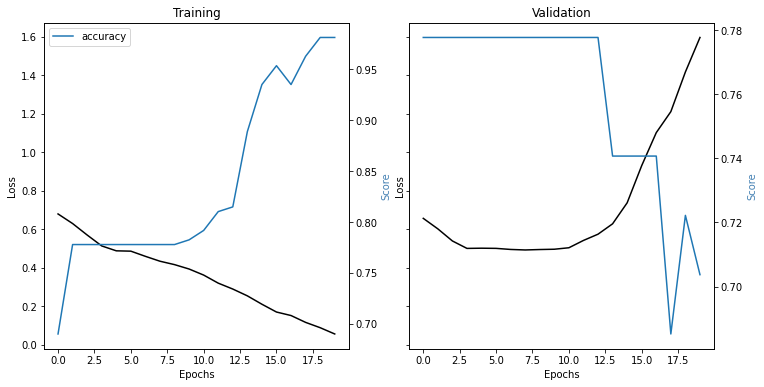

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(12,6)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in my_metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in my_metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
# save trained model
model.save('biLSTM_modelv1.h5')

In [ ]:
files.download('biLSTM_modelv1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the biLSTM Model

In [80]:
# y-predicted probas
predicted_prob = model.predict(X_test_padded)

In [81]:
predicted_prob[0:6]

array([[9.9998105e-01, 1.8984692e-05],
       [9.4608110e-01, 5.3918876e-02],
       [5.5053729e-01, 4.4946277e-01],
       [9.9999619e-01, 3.8318963e-06],
       [9.9998426e-01, 1.5758786e-05],
       [9.9999285e-01, 7.1598975e-06]], dtype=float32)

In [82]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
dic_y_mapping

{0: 0, 1: 1}

In [83]:
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
predicted[0:6]

[0, 0, 0, 0, 0, 0]

In [85]:
# Evaluation
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

In [86]:
# Our two classes
classes

array([0, 1])

In [87]:
y_test_array[0:6]

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [88]:
y_test.shape

(68,)

In [89]:
# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1], multi_class="ovr")

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.79
Auc: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        53
           1       0.56      0.33      0.42        15

    accuracy                           0.79        68
   macro avg       0.69      0.63      0.65        68
weighted avg       0.77      0.79      0.77        68



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

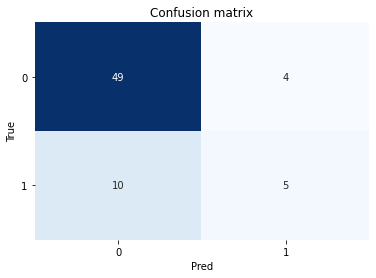

In [90]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

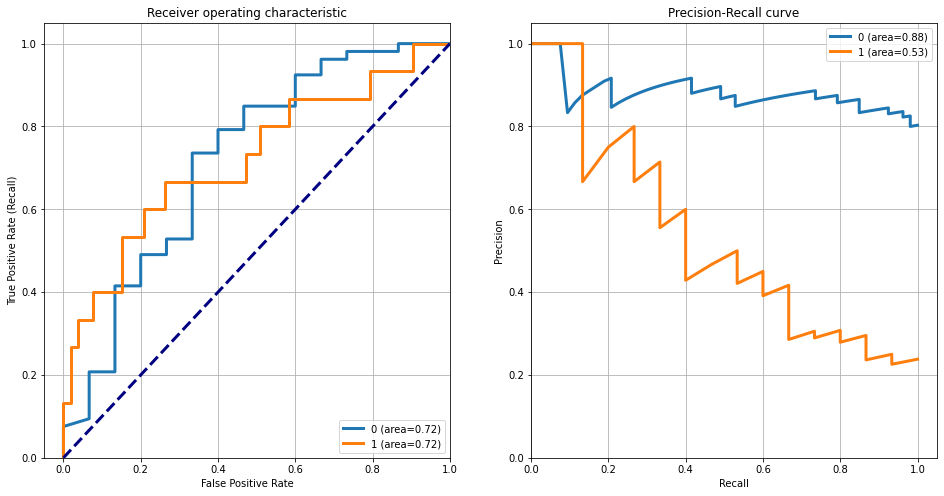

In [91]:
# ROC 

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16,8)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## Explainer 
### Attention Layer analysis for explanation
Extract weights for each word at the attention layer to find out how much influences each word in the classification decision. 

In [92]:
# select observation to be explained
i = 23
txt_instance = alex_df["Text"].iloc[i]
txt_instance

'Un niño que quería aprender a tocar el Violín y estaba triste por no poder escuchar su sonido debido a su problema de audición, de ahí su tristeza.'

In [94]:
tokens_instance = ast.literal_eval(alex_df["Tokens_Stop"].iloc[i])
tokens_instance

['niño',
 'quería',
 'aprender',
 'tocar',
 'violín',
 'triste',
 'poder',
 'escuchar',
 'sonido',
 'debido',
 'problema',
 'audición',
 'ahí',
 'tristeza']

In [95]:
# Check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

True: 0 --> Pred: 0 | Prob: 0.99


In [100]:
# Preprocessing the instance: 
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences([tokens_instance]), maxlen=MAX_LEN, 
              padding="post", truncating="post")

In [101]:
X_instance

array([[  3,  16,  41,   6,   2,  47,  33, 505, 331, 187, 506, 931,  72,
        932,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [105]:
# Get attentions layers from the model: 
att_layer = [layer for layer in model.layers if "attention" in layer.name][0]

In [106]:
func = K.function([model.input], [att_layer.output])
att_weights = func(X_instance)[0]

In [108]:
att_weights.shape

(1, 20, 400)

In [107]:
att_weights

array([[[0.04239682, 0.0830788 , 0.00287998, ..., 0.01193997,
         0.15438174, 0.07788416],
        [0.01136319, 0.0453606 , 0.03605289, ..., 0.01060301,
         0.02810443, 0.0076527 ],
        [0.12244739, 0.03182303, 0.02611584, ..., 0.02091423,
         0.00509572, 0.06181147],
        ...,
        [0.09093815, 0.03777584, 0.05424997, ..., 0.02915298,
         0.01175642, 0.02856686],
        [0.04633953, 0.01571235, 0.01918392, ..., 0.08483262,
         0.024366  , 0.02827669],
        [0.02230701, 0.00939755, 0.10111002, ..., 0.03286755,
         0.01055648, 0.01339688]]], dtype=float32)

In [109]:
# Average weight per sequence position
att_weights = np.mean(att_weights, axis=2).flatten()

In [110]:
att_weights.shape

(20,)

In [111]:
att_weights

array([0.03913404, 0.06626764, 0.05002942, 0.05556699, 0.04290662,
       0.05284418, 0.06566373, 0.07198596, 0.06573653, 0.04409574,
       0.050504  , 0.05599001, 0.03792918, 0.04053557, 0.05549785,
       0.05718025, 0.0405158 , 0.0344428 , 0.03764611, 0.03552755],
      dtype=float32)

In [113]:
# Rescale weights:
from sklearn import preprocessing
att_weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(att_weights).reshape(-1,1)).reshape(-1)

In [114]:
att_weights

array([0.12495595, 0.8476868 , 0.41516536, 0.5626642 , 0.22544259,
       0.49013942, 0.83160096, 1.        , 0.83354026, 0.25711602,
       0.42780632, 0.57393175, 0.0928635 , 0.16228718, 0.56082267,
       0.6056351 , 0.16176063, 0.        , 0.08532351, 0.02889347],
      dtype=float32)

In [117]:
# Remove weights of null vectors (sequence padding)
att_weights = [att_weights[n] for n,idx in enumerate(X_instance[0]) if idx != 0]

In [119]:
len(att_weights)

14

In [120]:
# Mapping words with weigths
dic_word_weigth = {word:att_weights[n] for n,word in 
                   enumerate(tokens_instance) if word in 
                   tokenizer.word_index.keys()}

In [121]:
dic_word_weigth

{'ahí': 0.0928635,
 'aprender': 0.41516536,
 'audición': 0.57393175,
 'debido': 0.25711602,
 'escuchar': 1.0,
 'niño': 0.12495595,
 'poder': 0.83160096,
 'problema': 0.42780632,
 'quería': 0.8476868,
 'sonido': 0.83354026,
 'tocar': 0.5626642,
 'triste': 0.49013942,
 'tristeza': 0.16228718,
 'violín': 0.22544259}

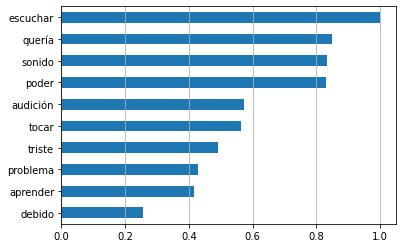

In [126]:
# See that in a barplot
top_N = 10
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(top_N).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")

In [127]:
# Enriched text (HTML) visualization
text = []
for word in tokens_instance:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)

In [130]:
print("Text with highlighted words by importance (attention):")
from IPython.core.display import display, HTML
display(HTML(text))

Text with highlighted words by importance (attention):
